**SKRIPSI//SEGMENTASI**


**IMPORT LIBRARIES DAN DEPENDENCIES SERTA RANDOM SEED GENERATOR**

In [ ]:
# Library Core & Sistem
import os
import io
import time
import gc
import random
import sys
from tqdm import tqdm
from glob import glob
import cv2

# Processing & Visualisai Data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageEnhance

#Widget Interaksi di Inference
from IPython.display import display
import ipywidgets as widgets

#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

#Transform
from torchvision import transforms
from torchvision.transforms import functional as TF

#Contour detection
from skimage import measure


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random Seed terkunci di: {seed}")

set_seed(42)


Random Seed terkunci di: 42


**SETTING GPU**

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU Ready." if torch.cuda.is_available() else "CPU Ready.")

GPU Ready.


**KONFIGURASI FOLDER PATH**

In [10]:
Base = r"C:\Riset Skripsi\DATASET_ASLI"

TRAIN_IMG_DIR = os.path.join(Base, "Train_T")
TRAIN_MASK_DIR = os.path.join(Base, "Mask_GT_Train")
VAL_IMG_DIR = os.path.join(Base, "Val_T")
VAL_MASK_DIR = os.path.join(Base, "Mask_GT_Val")
TEST_IMG_DIR = os.path.join(Base, "Test_T")
TEST_MASK_DIR = os.path.join(Base, "Mask_GT_Test")

#Cek ketersediaan
folder_paths = {
        "Train Images": TRAIN_IMG_DIR,
        "Train Mask": TRAIN_MASK_DIR,
        "Val Images": VAL_IMG_DIR,
        "Val Mask": VAL_MASK_DIR,
        "Test Images": TEST_IMG_DIR,
        "Test Mask": TEST_MASK_DIR
}

status = [f"{name}: Ditemukan ({path})" if os.path.exists(path) 
               else f"{name}: TIDAK DITEMUKAN ({path})" 
               for name, path in folder_paths.items()]

print("\n".join(status))

Train Images: Ditemukan (C:\Riset Skripsi\DATASET_ASLI\Train_T)
Train Mask: Ditemukan (C:\Riset Skripsi\DATASET_ASLI\Mask_GT_Train)
Val Images: Ditemukan (C:\Riset Skripsi\DATASET_ASLI\Val_T)
Val Mask: Ditemukan (C:\Riset Skripsi\DATASET_ASLI\Mask_GT_Val)
Test Images: Ditemukan (C:\Riset Skripsi\DATASET_ASLI\Test_T)
Test Mask: Ditemukan (C:\Riset Skripsi\DATASET_ASLI\Mask_GT_Test)


**PREPROSES DAN AUGMENTASI**

In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=True):
        self.image_paths = []
        self.mask_paths = []
        self.transform = transform

        images = glob(os.path.join(image_dir, '**', '*.png'), recursive=True) + \
                 glob(os.path.join(image_dir, '**', '*.jpg'), recursive=True) # Jaga-jaga ada jpg
        
        masks  = glob(os.path.join(mask_dir, '**', '*.png'), recursive=True) + \
                 glob(os.path.join(mask_dir, '**', '*.jpg'), recursive=True)

        image_map = {os.path.basename(f).replace("mask_", "").lower(): f for f in images}
        mask_map = {os.path.basename(f).replace("mask_", "").lower(): f for f in masks}

        common = sorted(set(image_map.keys()) & set(mask_map.keys()))
        
        for fname in common:
            self.image_paths.append(image_map[fname])
            self.mask_paths.append(mask_map[fname])

        print(f"Loaded {len(self.image_paths)} pairs correctly.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        FIXED_SIZE = (256, 256)
        
        image = Image.open(self.image_paths[idx]).convert("L")
        mask  = Image.open(self.mask_paths[idx]).convert("L") 
        image = TF.resize(image, FIXED_SIZE, interpolation=TF.InterpolationMode.BILINEAR)
        mask  = TF.resize(mask, FIXED_SIZE, interpolation=TF.InterpolationMode.NEAREST)

        if self.transform:
            if random.random() > 0.5:
                image, mask = TF.hflip(image), TF.hflip(mask)
            if random.random() > 0.5:
                image, mask = TF.vflip(image), TF.vflip(mask)
            
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                image = TF.rotate(image, angle, interpolation=TF.InterpolationMode.BILINEAR, fill=255) 
                mask  = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST, fill=255) 

            if random.random() > 0.5:
                factor = random.uniform(0.8, 1.2)
                image = TF.adjust_brightness(image, factor)
    
        image_tensor = TF.to_tensor(image) 
        mask_tensor  = TF.to_tensor(mask)  
        mask_tensor = 1.0 - mask_tensor 
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor

**ARSITEKTUR U-NET, DOUBLECONV, ENCO,DECO (MODEL)**


In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.double_conv(x)
        x_pooled = self.pool(x_conv)
        return x_conv, x_pooled

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.double_conv = DoubleConv(out_channels * 2, out_channels)
        self.dropout = nn.Dropout(dropout_prob) if dropout_prob > 0 else nn.Identity()

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.double_conv(x)
        return self.dropout(x) 

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, use_sigmoid=False):
        super(UNet, self).__init__()
        self.use_sigmoid = use_sigmoid

        # Encoder
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            DoubleConv(512, 1024),
            nn.Dropout(0.3) 
        )

        # Decoder
        self.dec1 = DecoderBlock(1024, 512, dropout_prob=0.2)
        self.dec2 = DecoderBlock(512, 256, dropout_prob=0.2)
        self.dec3 = DecoderBlock(256, 128, dropout_prob=0.1)
        self.dec4 = DecoderBlock(128, 64,  dropout_prob=0.1)

        # Output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self._init_weights()

    def forward(self, x):
        s1, x = self.enc1(x)
        s2, x = self.enc2(x)
        s3, x = self.enc3(x)
        s4, x = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, s4)
        x = self.dec2(x, s3)
        x = self.dec3(x, s2)
        x = self.dec4(x, s1)

        x = self.final_conv(x)
        
        if self.use_sigmoid:
            return torch.sigmoid(x)
        return x 

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

**LOAD data loader**

In [13]:
train_ds = SegmentationDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=True)
val_ds = SegmentationDataset(VAL_IMG_DIR, VAL_MASK_DIR, transform=False)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

Loaded 288 pairs correctly.
Loaded 72 pairs correctly.


**CHECKPOINT MODEL**

In [14]:
class ModelCheckpoint:
    """
    Menyimpan model setiap kali performa meningkat.
    Bisa untuk Loss (makin kecil makin baik) atau IoU (makin besar makin baik).
    """
    def __init__(self, save_path='best_model.pth', mode='max', verbose=True):
        self.save_path = save_path
        self.mode = mode
        self.verbose = verbose
        if mode == 'min':
            self.best_score = float('inf')
        else:
            self.best_score = -float('inf')

    def __call__(self, model, score, epoch):
        if self.mode == 'min':
            is_better = score < self.best_score
        else:
            is_better = score > self.best_score

        if is_better:
            if self.verbose:
                print(f"\n Saving model...")
            
            self.best_score = score
            torch.save(model.state_dict(), self.save_path)


**SETUP MODEL DAN OPTIMIZER**

In [15]:
model = UNet(in_channels=1, out_channels=1, use_sigmoid=True).to(device)
bce = nn.BCELoss() 

def dice_loss(pred, target, smooth=1e-6):
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    return bce(pred, target) + dice_loss(pred, target)

def dice_coefficient(pred, target, smooth=1e-6):
    pred_bin = (pred > 0.5).float() 
    intersection = (pred_bin * target).sum(dim=(2, 3))
    union = pred_bin.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def accuracy_score(pred, target):
    pred = (pred > 0.5).float()
    return (pred == target).float().mean()

def iou_score(pred, target):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return inter / (union + 1e-7)

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',      
    factor=0.5,      
    patience=5,      
)


checkpoint = ModelCheckpoint(mode='max', verbose=True)

train_loss, train_acc, train_dice, train_iou = [], [], [], []
val_loss, val_acc, val_dice, val_iou = [], [], [], []


**TRAINING LOOP**

In [16]:
NUM_EPOCHS = 50


print(f"Memulai Training untuk {NUM_EPOCHS} Epochs...")
print("-" * 80)

train_loss, train_acc, train_dice, train_iou = [], [], [], []
val_loss, val_acc, val_dice, val_iou = [], [], [], []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    tloss, tacc, tdice, tiou = 0, 0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Train]", leave=False)
    
    for i, (imgs, masks) in enumerate(train_loader_tqdm):
        imgs, masks = imgs.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs) 
        
        loss = combined_loss(outputs, masks)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() 

        tloss += loss.item()
        tacc  += accuracy_score(outputs, masks).item()
        tdice += dice_coefficient(outputs, masks)
        tiou  += iou_score(outputs, masks).item()

        train_loader_tqdm.set_postfix({"Loss": f"{loss.item():.4f}"})

    model.eval()
    vloss, vacc, vdice, viou = 0, 0, 0, 0

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Val]", leave=False)
    
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(val_loader_tqdm):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            vloss += combined_loss(outputs, masks).item()
            vacc  += accuracy_score(outputs, masks).item()
            vdice += dice_coefficient(outputs, masks) 
            viou  += iou_score(outputs, masks).item()
            
            val_loader_tqdm.set_postfix({"Val Loss": f"{vloss/(i+1):.4f}"})


    avg_tloss = tloss / len(train_loader)
    avg_tacc  = tacc  / len(train_loader)
    avg_tdice = tdice / len(train_loader) 
    avg_tiou  = tiou  / len(train_loader)
    
    avg_vloss = vloss / len(val_loader)
    avg_vacc  = vacc  / len(val_loader)
    avg_vdice = vdice / len(val_loader) 
    avg_viou  = viou  / len(val_loader)
    
    train_loss.append(avg_tloss); train_iou.append(avg_tiou); train_dice.append(avg_tdice); train_acc.append(avg_tacc)
    val_loss.append(avg_vloss);   val_iou.append(avg_viou);   val_dice.append(avg_vdice);   val_acc.append(avg_vacc)

    print(f"Epoch {epoch:03d}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_tloss:.4f} IoU: {avg_tiou:.4f} Acc: {avg_tacc:.4f}| "
          f"Val Loss: {avg_vloss:.4f} IoU: {avg_viou:.4f} Acc: {avg_vacc:.4f}")   

    checkpoint(model, avg_viou, epoch)
    scheduler.step(avg_viou)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"   └── LR: {current_lr:.6f}")

    
    sys.stdout.flush() 

print("\n Training Selesai Sepenuhnya.")

Memulai Training untuk 50 Epochs...
--------------------------------------------------------------------------------


Epoch 001/50 | Train Loss: 0.5407 IoU: 0.7676 Acc: 0.9592| Val Loss: 0.3281 IoU: 0.8189 Acc: 0.9751

 Saving model...
   └── LR: 0.001000


Epoch 002/50 | Train Loss: 0.2676 IoU: 0.8228 Acc: 0.9792| Val Loss: 0.2295 IoU: 0.8277 Acc: 0.9762

 Saving model...
   └── LR: 0.001000


Epoch 003/50 | Train Loss: 0.2047 IoU: 0.8294 Acc: 0.9800| Val Loss: 0.2072 IoU: 0.8281 Acc: 0.9769

 Saving model...
   └── LR: 0.001000


Epoch 004/50 | Train Loss: 0.1848 IoU: 0.8318 Acc: 0.9803| Val Loss: 0.2009 IoU: 0.8336 Acc: 0.9774

 Saving model...
   └── LR: 0.001000


Epoch 005/50 | Train Loss: 0.1730 IoU: 0.8362 Acc: 0.9810| Val Loss: 0.1960 IoU: 0.8341 Acc: 0.9773

 Saving model...
   └── LR: 0.001000


Epoch 006/50 | Train Loss: 0.1702 IoU: 0.8356 Acc: 0.9809| Val Loss: 0.1987 IoU: 0.8289 Acc: 0.9763
   └── LR: 0.001000


Epoch 007/50 | Train Loss: 0.1631 IoU: 0.8421 Acc: 0.9815| Val Loss: 0.1801 IoU: 0.8419 Acc: 0.9783

 Saving model...
   └── LR: 0.001000


Epoch 008/50 | Train Loss: 0.1617 IoU: 0.8430 Acc: 0.9816| Val Loss: 0.2030 IoU: 0.8117 Acc: 0.9740
   └── LR: 0.001000


Epoch 009/50 | Train Loss: 0.1641 IoU: 0.8437 Acc: 0.9814| Val Loss: 0.1904 IoU: 0.8358 Acc: 0.9777
   └── LR: 0.001000


Epoch 010/50 | Train Loss: 0.1632 IoU: 0.8387 Acc: 0.9812| Val Loss: 0.1815 IoU: 0.8375 Acc: 0.9775
   └── LR: 0.001000


Epoch 011/50 | Train Loss: 0.1608 IoU: 0.8404 Acc: 0.9813| Val Loss: 0.1676 IoU: 0.8417 Acc: 0.9783
   └── LR: 0.001000


Epoch 012/50 | Train Loss: 0.1579 IoU: 0.8432 Acc: 0.9814| Val Loss: 0.1707 IoU: 0.8412 Acc: 0.9780
   └── LR: 0.001000


Epoch 013/50 | Train Loss: 0.1548 IoU: 0.8454 Acc: 0.9818| Val Loss: 0.1774 IoU: 0.8358 Acc: 0.9774
   └── LR: 0.000500


Epoch 014/50 | Train Loss: 0.1506 IoU: 0.8480 Acc: 0.9821| Val Loss: 0.1628 IoU: 0.8434 Acc: 0.9786

 Saving model...
   └── LR: 0.000500


Epoch 015/50 | Train Loss: 0.1486 IoU: 0.8495 Acc: 0.9822| Val Loss: 0.1621 IoU: 0.8479 Acc: 0.9790

 Saving model...
   └── LR: 0.000500


Epoch 016/50 | Train Loss: 0.1481 IoU: 0.8524 Acc: 0.9827| Val Loss: 0.1622 IoU: 0.8469 Acc: 0.9787
   └── LR: 0.000500


Epoch 017/50 | Train Loss: 0.1482 IoU: 0.8550 Acc: 0.9826| Val Loss: 0.1632 IoU: 0.8480 Acc: 0.9790

 Saving model...
   └── LR: 0.000500


Epoch 018/50 | Train Loss: 0.1473 IoU: 0.8511 Acc: 0.9823| Val Loss: 0.1597 IoU: 0.8491 Acc: 0.9790

 Saving model...
   └── LR: 0.000500


Epoch 019/50 | Train Loss: 0.1472 IoU: 0.8556 Acc: 0.9826| Val Loss: 0.1525 IoU: 0.8529 Acc: 0.9796

 Saving model...
   └── LR: 0.000500


Epoch 020/50 | Train Loss: 0.1441 IoU: 0.8529 Acc: 0.9825| Val Loss: 0.1509 IoU: 0.8531 Acc: 0.9796

 Saving model...
   └── LR: 0.000500


Epoch 021/50 | Train Loss: 0.1440 IoU: 0.8546 Acc: 0.9828| Val Loss: 0.1585 IoU: 0.8506 Acc: 0.9793
   └── LR: 0.000500


Epoch 022/50 | Train Loss: 0.1421 IoU: 0.8566 Acc: 0.9830| Val Loss: 0.1601 IoU: 0.8493 Acc: 0.9793
   └── LR: 0.000500


Epoch 023/50 | Train Loss: 0.1447 IoU: 0.8524 Acc: 0.9827| Val Loss: 0.1565 IoU: 0.8474 Acc: 0.9787
   └── LR: 0.000500


Epoch 024/50 | Train Loss: 0.1433 IoU: 0.8533 Acc: 0.9829| Val Loss: 0.1660 IoU: 0.8461 Acc: 0.9786
   └── LR: 0.000500


Epoch 025/50 | Train Loss: 0.1454 IoU: 0.8561 Acc: 0.9830| Val Loss: 0.1583 IoU: 0.8527 Acc: 0.9796
   └── LR: 0.000500


Epoch 026/50 | Train Loss: 0.1447 IoU: 0.8550 Acc: 0.9828| Val Loss: 0.1552 IoU: 0.8547 Acc: 0.9799

 Saving model...
   └── LR: 0.000500


Epoch 027/50 | Train Loss: 0.1427 IoU: 0.8560 Acc: 0.9829| Val Loss: 0.1548 IoU: 0.8541 Acc: 0.9797
   └── LR: 0.000500


Epoch 028/50 | Train Loss: 0.1430 IoU: 0.8512 Acc: 0.9828| Val Loss: 0.1588 IoU: 0.8551 Acc: 0.9799

 Saving model...
   └── LR: 0.000500


Epoch 029/50 | Train Loss: 0.1412 IoU: 0.8536 Acc: 0.9830| Val Loss: 0.1538 IoU: 0.8520 Acc: 0.9796
   └── LR: 0.000500


Epoch 030/50 | Train Loss: 0.1447 IoU: 0.8567 Acc: 0.9830| Val Loss: 0.1741 IoU: 0.8521 Acc: 0.9795
   └── LR: 0.000500


Epoch 031/50 | Train Loss: 0.1406 IoU: 0.8564 Acc: 0.9830| Val Loss: 0.1525 IoU: 0.8533 Acc: 0.9797
   └── LR: 0.000500


Epoch 032/50 | Train Loss: 0.1364 IoU: 0.8612 Acc: 0.9835| Val Loss: 0.1569 IoU: 0.8485 Acc: 0.9793
   └── LR: 0.000500


Epoch 033/50 | Train Loss: 0.1372 IoU: 0.8587 Acc: 0.9832| Val Loss: 0.1516 IoU: 0.8539 Acc: 0.9798
   └── LR: 0.000500


Epoch 034/50 | Train Loss: 0.1369 IoU: 0.8581 Acc: 0.9834| Val Loss: 0.1501 IoU: 0.8526 Acc: 0.9797
   └── LR: 0.000250


Epoch 035/50 | Train Loss: 0.1340 IoU: 0.8597 Acc: 0.9835| Val Loss: 0.1473 IoU: 0.8572 Acc: 0.9802

 Saving model...
   └── LR: 0.000250


Epoch 036/50 | Train Loss: 0.1318 IoU: 0.8610 Acc: 0.9837| Val Loss: 0.1487 IoU: 0.8555 Acc: 0.9800
   └── LR: 0.000250


Epoch 037/50 | Train Loss: 0.1341 IoU: 0.8609 Acc: 0.9837| Val Loss: 0.1456 IoU: 0.8585 Acc: 0.9803

 Saving model...
   └── LR: 0.000250


Epoch 038/50 | Train Loss: 0.1335 IoU: 0.8609 Acc: 0.9838| Val Loss: 0.1492 IoU: 0.8546 Acc: 0.9800
   └── LR: 0.000250


Epoch 039/50 | Train Loss: 0.1328 IoU: 0.8636 Acc: 0.9838| Val Loss: 0.1471 IoU: 0.8576 Acc: 0.9803
   └── LR: 0.000250


Epoch 040/50 | Train Loss: 0.1305 IoU: 0.8630 Acc: 0.9840| Val Loss: 0.1420 IoU: 0.8595 Acc: 0.9805

 Saving model...
   └── LR: 0.000250


Epoch 041/50 | Train Loss: 0.1287 IoU: 0.8643 Acc: 0.9842| Val Loss: 0.1444 IoU: 0.8596 Acc: 0.9805

 Saving model...
   └── LR: 0.000250


Epoch 042/50 | Train Loss: 0.1316 IoU: 0.8613 Acc: 0.9838| Val Loss: 0.1443 IoU: 0.8599 Acc: 0.9805

 Saving model...
   └── LR: 0.000250


Epoch 043/50 | Train Loss: 0.1366 IoU: 0.8627 Acc: 0.9838| Val Loss: 0.1486 IoU: 0.8566 Acc: 0.9801
   └── LR: 0.000250


Epoch 044/50 | Train Loss: 0.1321 IoU: 0.8651 Acc: 0.9838| Val Loss: 0.1453 IoU: 0.8591 Acc: 0.9804
   └── LR: 0.000250


Epoch 045/50 | Train Loss: 0.1313 IoU: 0.8638 Acc: 0.9838| Val Loss: 0.1405 IoU: 0.8606 Acc: 0.9805

 Saving model...
   └── LR: 0.000250


Epoch 046/50 | Train Loss: 0.1302 IoU: 0.8594 Acc: 0.9838| Val Loss: 0.1470 IoU: 0.8598 Acc: 0.9804
   └── LR: 0.000250


Epoch 047/50 | Train Loss: 0.1336 IoU: 0.8614 Acc: 0.9838| Val Loss: 0.1486 IoU: 0.8557 Acc: 0.9801
   └── LR: 0.000250


Epoch 048/50 | Train Loss: 0.1268 IoU: 0.8665 Acc: 0.9842| Val Loss: 0.1424 IoU: 0.8611 Acc: 0.9806

 Saving model...
   └── LR: 0.000250


Epoch 049/50 | Train Loss: 0.1307 IoU: 0.8640 Acc: 0.9841| Val Loss: 0.1414 IoU: 0.8610 Acc: 0.9806
   └── LR: 0.000250


Epoch 050/50 | Train Loss: 0.1303 IoU: 0.8664 Acc: 0.9842| Val Loss: 0.1385 IoU: 0.8616 Acc: 0.9807

 Saving model...
   └── LR: 0.000250

 Training Selesai Sepenuhnya.


**EVALUASI**

Semua history (Loss, IoU, Dice, Acc) berhasil disimpan.


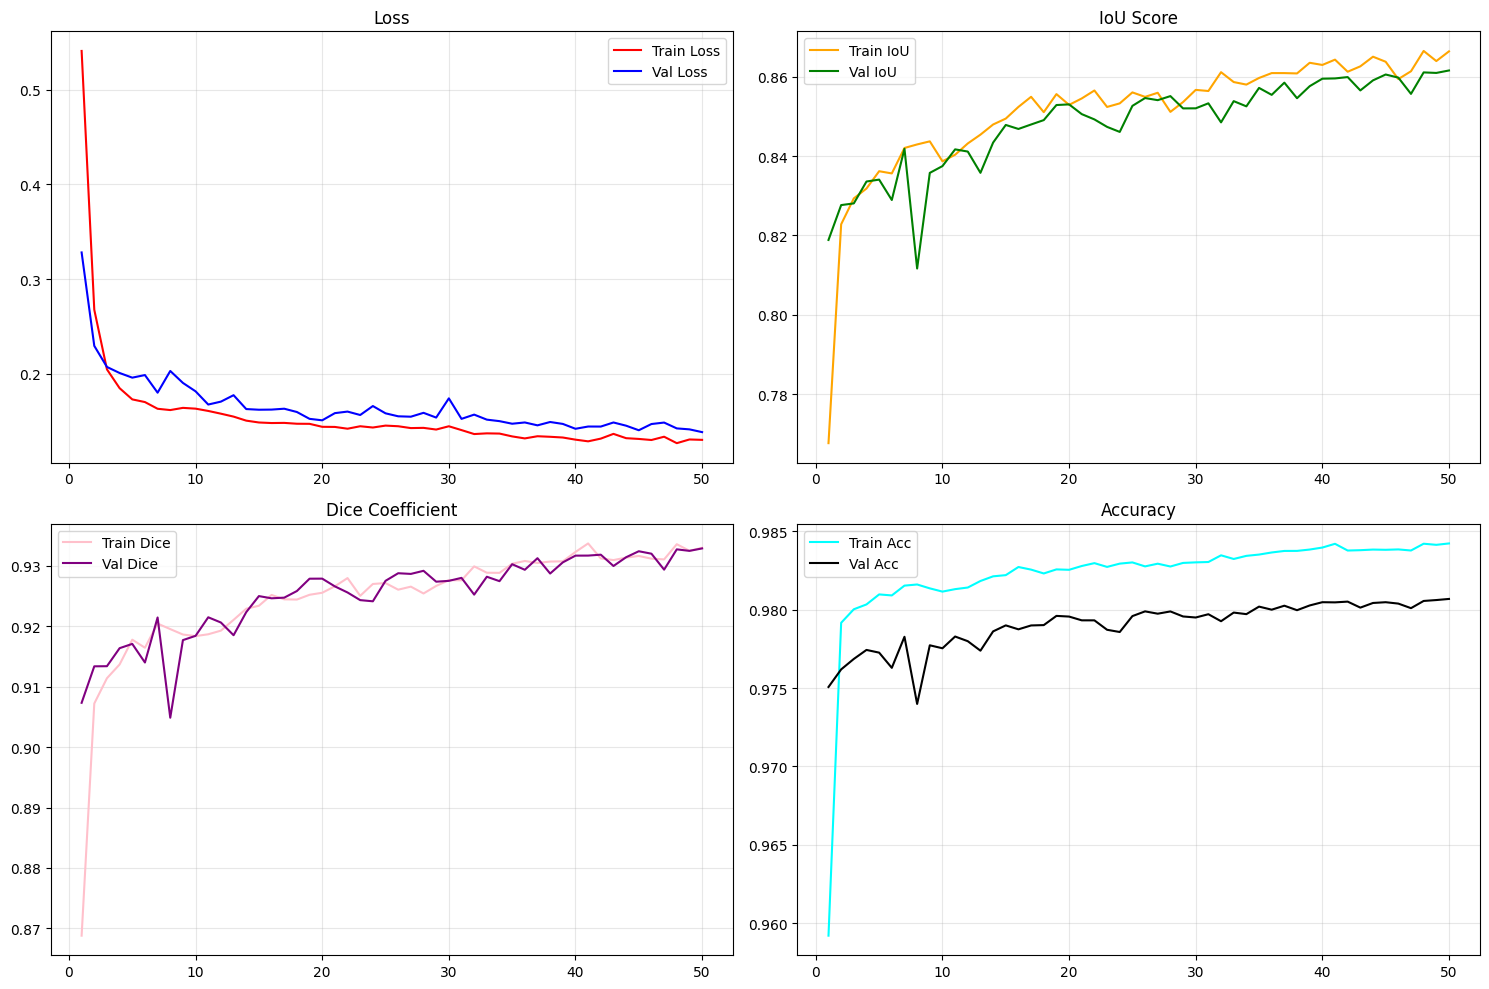


Performa(Pada Epoch 50)
1. IoU SCORE (Intersection over Union)
   • Train IoU      : 0.8664
   • Validation IoU : 0.8616

2. DICE COEFFICIENT (F1 Score)
   • Train Dice     : 0.9330
   • Validation Dice: 0.9329

3. ACCURACY
   • Train Acc      : 98.42%
   • Validation Acc : 98.07%
--------------------------------------------------
LOSS
   • Train Loss     : 0.1303
   • Validation Loss: 0.1385


In [17]:
try:
    np.save("history_train_loss.npy", np.array(train_loss))
    np.save("history_val_loss.npy",   np.array(val_loss))
    
    np.save("history_train_iou.npy",  np.array(train_iou))
    np.save("history_val_iou.npy",    np.array(val_iou))
    
    np.save("history_train_dice.npy", np.array(train_dice))
    np.save("history_val_dice.npy",   np.array(val_dice))
    
    np.save("history_train_acc.npy",  np.array(train_acc))
    np.save("history_val_acc.npy",    np.array(val_acc))   
    
    print("Semua history (Loss, IoU, Dice, Acc) berhasil disimpan.")
except Exception as e:
    print(f"Info: {e}")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(15, 10)) 

# Grafik 1: LOSS
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='red')
plt.plot(epochs, val_loss, label='Val Loss', color='blue')
plt.title('Loss')
plt.legend(); plt.grid(True, alpha=0.3)

# Grafik 2: IoU
plt.subplot(2, 2, 2)
plt.plot(epochs, train_iou, label='Train IoU', color='orange')
plt.plot(epochs, val_iou, label='Val IoU', color='green')
plt.title('IoU Score')
plt.legend(); plt.grid(True, alpha=0.3)

# Grafik 3: Dice Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_dice, label='Train Dice', color='pink')
plt.plot(epochs, val_dice, label='Val Dice', color='purple')
plt.title('Dice Coefficient')
plt.legend(); plt.grid(True, alpha=0.3)

# Grafik 4: ACCURACY
plt.subplot(2, 2, 4)
plt.plot(epochs, train_acc, label='Train Acc', color='cyan')
plt.plot(epochs, val_acc, label='Val Acc', color='black')
plt.title('Accuracy')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Grafik_Performa_Lengkap.png", dpi=300)
plt.show()

if len(val_iou) > 0:
    best_epoch_idx = np.argmax(val_iou) 
    best_epoch = best_epoch_idx + 1

    print("\n" + "="*50)
    print(f"Performa(Pada Epoch {best_epoch})")
    print("="*50)
    
    print(f"1. IoU SCORE (Intersection over Union)")
    print(f"   • Train IoU      : {train_iou[best_epoch_idx]:.4f}")
    print(f"   • Validation IoU : {val_iou[best_epoch_idx]:.4f}")
    
    print(f"\n2. DICE COEFFICIENT (F1 Score)")
    print(f"   • Train Dice     : {train_dice[best_epoch_idx]:.4f}")
    print(f"   • Validation Dice: {val_dice[best_epoch_idx]:.4f}")
    
    print(f"\n3. ACCURACY")
    print(f"   • Train Acc      : {train_acc[best_epoch_idx]*100:.2f}%") 
    print(f"   • Validation Acc : {val_acc[best_epoch_idx]*100:.2f}%")
    
    print("-" * 50)
    print(f"LOSS")
    print(f"   • Train Loss     : {train_loss[best_epoch_idx]:.4f}")
    print(f"   • Validation Loss: {val_loss[best_epoch_idx]:.4f}")
    print("="*50)
else:
    print("Data belum cukup untuk menampilkan hasil")

In [18]:
Base = r"C:\Riset Skripsi\DATASET_ASLI"

TEST_IMG_BASE = os.path.join(Base, "Test_T")
TEST_MASK_BASE = os.path.join(Base, "Mask_GT_Test")

test_sets = {
    "Ferrimagnetic": (
        os.path.join(TEST_IMG_BASE, "Ferrimagnetic"), 
        os.path.join(TEST_MASK_BASE, "Ferrimagnetic")
    ),
    "Ferromagnetic": (
        os.path.join(TEST_IMG_BASE, "Ferromagnetic"),
        os.path.join(TEST_MASK_BASE, "Ferromagnetic")
    ),
    "Non_Magnetic": (
        os.path.join(TEST_IMG_BASE, "Non_Magnetic"),
        os.path.join(TEST_MASK_BASE, "Non_Magnetic")
    )
}

class TestTransform:
    """Mengubah gambar jadi Tensor tanpa augmentasi aneh-aneh"""
    def __call__(self, image, mask):
        image = TF.resize(image, [256, 256])
        mask = TF.resize(mask, [256, 256])
        
        image = TF.to_tensor(image) 
        mask = TF.to_tensor(mask)
        return image, mask

print("\n MEMULAI EVALUASI TEST SET PER KELAS...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=1, out_channels=1, use_sigmoid=True).to(device)

try:
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    print("Model berhasil dimuat: 'best_model.pth'")
except FileNotFoundError:
    print(" ERROR: File model tidak ditemukan! Pastikan sudah training dulu.")

model.eval()
results = []

for class_name, (test_img_dir, test_mask_dir) in test_sets.items():
    print(f"\n🔹 Evaluasi kelas: {class_name}")

    if not os.path.exists(test_img_dir):
        print(f"Folder Image tidak ditemukan: {test_img_dir}")
        continue
    if not os.path.exists(test_mask_dir):
        print(f"Folder Mask tidak ditemukan: {test_mask_dir}")
        continue
    
    try:
        test_ds = SegmentationDataset(test_img_dir, test_mask_dir, transform=TestTransform())
    except Exception as e:
        print(f"Error dataset: {e}")
        continue

    if len(test_ds) == 0:
        print(f"Folder kosong. Lewati.")
        continue

    print(f"   → Ditemukan {len(test_ds)} data.")
    
    test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=0)

    test_loss, test_acc, test_dice, test_iou = 0.0, 0.0, 0.0, 0.0
    num_batches = len(test_loader)

    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc=f"   Testing...", leave=False):
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()

            outputs = model(imgs)

            test_loss += combined_loss(outputs, masks).item()
            test_acc  += accuracy_score(outputs, masks).item()
            test_dice += dice_coefficient(outputs, masks)
            test_iou  += iou_score(outputs, masks).item()

    results.append({
        "Class": class_name,
        "IoU": test_iou / num_batches,
        "Dice": test_dice / num_batches,
        "Accuracy": test_acc / num_batches,
        "Loss": test_loss / num_batches
    })

print("\n" + "="*70)
print(f"LAPORAN PERFORMA PENGUJIAN (TEST SET)")
print("="*70)
print(f"{'Kategori Kelas':<20} {'IoU':>10} {'Dice':>10} {'Acc (%)':>12} {'Loss':>10}")
print("-" * 70)

for r in results:
    print(f"{r['Class']:<20} {r['IoU']:>10.4f} {r['Dice']:>10.4f} {r['Accuracy']*100:>11.2f}% {r['Loss']:>10.4f}")

print("="*70)


 MEMULAI EVALUASI TEST SET PER KELAS...
Model berhasil dimuat: 'best_model.pth'

🔹 Evaluasi kelas: Ferrimagnetic
Loaded 15 pairs correctly.
   → Ditemukan 15 data.



🔹 Evaluasi kelas: Ferromagnetic
Loaded 15 pairs correctly.
   → Ditemukan 15 data.



🔹 Evaluasi kelas: Non_Magnetic
Loaded 15 pairs correctly.
   → Ditemukan 15 data.



LAPORAN PERFORMA PENGUJIAN (TEST SET)
Kategori Kelas              IoU       Dice      Acc (%)       Loss
----------------------------------------------------------------------
Ferrimagnetic            0.6534     0.8054       93.33%     0.4583
Ferromagnetic            0.7921     0.8821       96.89%     0.2879
Non_Magnetic             0.8800     0.9343       98.43%     0.1293


**TEST SEGMENTASI**

In [19]:
# --- 1. DEFINISI ARSITEKTUR 
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.double_conv(x)
        x_pooled = self.pool(x_conv)
        return x_conv, x_pooled

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.double_conv = DoubleConv(out_channels * 2, out_channels)
        self.dropout = nn.Dropout(dropout_prob) if dropout_prob > 0 else nn.Identity()

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.double_conv(x)
        return self.dropout(x) 

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, use_sigmoid=False):
        super(UNet, self).__init__()
        self.use_sigmoid = use_sigmoid

        # Encoder
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            DoubleConv(512, 1024),
            nn.Dropout(0.3) 
        )

        # Decoder
        self.dec1 = DecoderBlock(1024, 512, dropout_prob=0.2)
        self.dec2 = DecoderBlock(512, 256, dropout_prob=0.2)
        self.dec3 = DecoderBlock(256, 128, dropout_prob=0.1)
        self.dec4 = DecoderBlock(128, 64,  dropout_prob=0.1)

        # Output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self._init_weights()

    def forward(self, x):
        s1, x = self.enc1(x)
        s2, x = self.enc2(x)
        s3, x = self.enc3(x)
        s4, x = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, s4)
        x = self.dec2(x, s3)
        x = self.dec3(x, s2)
        x = self.dec4(x, s1)

        x = self.final_conv(x)
        
        if self.use_sigmoid:
            return torch.sigmoid(x)
        return x 

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1, use_sigmoid=True).to(device)

model_path = "best_model.pth" 

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model '{model_path}' berhasil dimuat")
except Exception as e:
    print(f"Error: {e}. Cek nama file")

model.eval()

uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False, description="Upload Gambar")
btn_process = widgets.Button(description="Proses", button_style='success')
output_view = widgets.Output()

def run_segmentation(b):
    output_view.clear_output()
    
    if not uploader.value:
        with output_view: print("Harap upload gambar dulu!")
        return

    with output_view:
        start_time = time.time()
        
        try: uploaded_file = uploader.value[0]
        except: uploaded_file = list(uploader.value.values())[0]
            
        content = uploaded_file['content']
        
        # 1. Buka Gambar & Grayscale
        image_pil = Image.open(io.BytesIO(content))
        original_size = image_pil.size
        image_gray = image_pil.convert("L") 
        
        # 2. Transformasi
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        input_tensor = transform(image_gray).unsqueeze(0).to(device)

        # 3. Inference
        with torch.no_grad():
            output = model(input_tensor)
            output_resized = F.interpolate(
                output, size=(original_size[1], original_size[0]),
                mode='bilinear', align_corners=False
            )
            pred_prob = output_resized.squeeze().cpu().numpy()
            mask = (pred_prob > 0.5).astype(np.uint8)

        # 4. Post-Processing
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

        # 5. Visualisasi
        image_rgb = image_pil.convert("RGB")
        
        dark_bg = ImageEnhance.Brightness(image_rgb).enhance(0.5) 
        
        contours = measure.find_contours(mask_clean, 0.5)
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        
        # A. Original
        ax[0].imshow(image_rgb)
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        
        # B. Mask
        ax[1].imshow(mask_clean, cmap='gray_r') 
        ax[1].set_title("Predicted Mask")
        ax[1].axis("off")
        
        # C. Overlay
        ax[2].imshow(dark_bg)
        for contour in contours:
            ax[2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
        ax[2].set_title("Overlay (Red Contour)")
        ax[2].axis("off")
        
        plt.tight_layout()
        plt.show()
        
        print(f"Selesai dalam {time.time() - start_time:.4f} detik.")

btn_process.on_click(run_segmentation)
display(widgets.VBox([uploader, btn_process, output_view]))

Model 'best_model.pth' berhasil dimuat


**Inference untuk klasifikasi**

In [20]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.double_conv(x)
        x_pooled = self.pool(x_conv)
        return x_conv, x_pooled

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.double_conv = DoubleConv(out_channels * 2, out_channels)
        self.dropout = nn.Dropout(dropout_prob) if dropout_prob > 0 else nn.Identity()

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.double_conv(x)
        return self.dropout(x) 

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, use_sigmoid=False):
        super(UNet, self).__init__()
        self.use_sigmoid = use_sigmoid

        # Encoder
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            DoubleConv(512, 1024),
            nn.Dropout(0.3) 
        )

        # Decoder
        self.dec1 = DecoderBlock(1024, 512, dropout_prob=0.2)
        self.dec2 = DecoderBlock(512, 256, dropout_prob=0.2)
        self.dec3 = DecoderBlock(256, 128, dropout_prob=0.1)
        self.dec4 = DecoderBlock(128, 64,  dropout_prob=0.1)

        # Output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self._init_weights()

    def forward(self, x):
        s1, x = self.enc1(x)
        s2, x = self.enc2(x)
        s3, x = self.enc3(x)
        s4, x = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, s4)
        x = self.dec2(x, s3)
        x = self.dec3(x, s2)
        x = self.dec4(x, s1)

        x = self.final_conv(x)
        
        if self.use_sigmoid:
            return torch.sigmoid(x)
        return x 

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

# ===== SETUP MODEL - PERSIS SEPERTI KODE TEST =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1, use_sigmoid=True).to(device)

model_path = "best_model.pth"  # Ganti dengan nama model-mu

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model '{model_path}' berhasil dimuat")
except Exception as e:
    print(f"Error: {e}. Cek nama file")
    exit()

model.eval()

SOURCE_DIR = r"C:\Riset Skripsi\DATASET_ASLI"
OUTPUT_DIR = r"C:\Riset Skripsi\DATASET_ASLI\DATA_MASK_HASIL_UNET"

# (Semua import dan class UNet sama seperti sebelumnya)

def process_single_image(image_path, save_path):
    """Inference 1 gambar dengan background putih"""
    
    image_pil = Image.open(image_path)
    original_size = image_pil.size
    image_gray = image_pil.convert("L")
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    input_tensor = transform(image_gray).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        output_resized = F.interpolate(
            output, size=(original_size[1], original_size[0]),
            mode='bilinear', align_corners=False
        )
        pred_prob = output_resized.squeeze().cpu().numpy()
        mask = (pred_prob > 0.5).astype(np.uint8)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # ⭐ INVERT untuk background putih
    mask_final = (1 - mask_clean) * 255
    
    cv2.imwrite(save_path, mask_final.astype(np.uint8))
    
    return True


def process_dataset():
    classes = ["Ferrimagnetic", "Ferromagnetic", "Non_Magnetic"]
    
    print("="*70)
    print("MULAI BATCH INFERENCE - IDENTIK DENGAN KODE TEST")
    print("="*70)
    print(f"Source: {SOURCE_DIR}")
    print(f"Output: {OUTPUT_DIR}")
    print(f"Device: {device}")
    print("="*70)
    
    total_images = 0
    total_time = 0
    
    for class_name in classes:
        src_class_path = os.path.join(SOURCE_DIR, "Train_T", class_name)
        
        if not os.path.exists(src_class_path):
            src_class_path = os.path.join(SOURCE_DIR, class_name)
            if not os.path.exists(src_class_path):
                print(f"Folder '{class_name}' tidak ditemukan, skip...")
                continue
        
        # Buat output folder
        dst_class_path = os.path.join(OUTPUT_DIR, class_name)
        os.makedirs(dst_class_path, exist_ok=True)
        
        files = [f for f in os.listdir(src_class_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
        if len(files) == 0:
            print(f" Tidak ada gambar di '{class_name}'")
            continue
        
        print(f"\n Processing Kelas: {class_name} ({len(files)} gambar)")
        print("-" * 70)
        
        class_start = time.time()
        
        for idx, filename in enumerate(files, 1):
            img_path = os.path.join(src_class_path, filename)
            save_path = os.path.join(dst_class_path, filename)
            
            try:
                elapsed = process_single_image(img_path, save_path)
                total_time += elapsed
                total_images += 1
                
                if idx % 10 == 0:
                    avg_time = elapsed
                    print(f"  ✓ {idx}/{len(files)} | {filename[:30]:<30} | {avg_time:.3f}s")
                
                if idx % 50 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"Error pada '{filename}': {e}")
                continue
        
        class_time = time.time() - class_start
        print(f"Kelas {class_name} selesai dalam {class_time:.2f} detik")
    
    print("\n" + "="*70)
    print(" BATCH INFERENCE SELESAI!")
    print("="*70)
    print(f" Total gambar diproses: {total_images}")
    print(f" Total waktu: {total_time:.2f} detik")
    if total_images > 0:
        print(f"Rata-rata per gambar: {total_time/total_images:.3f} detik")
    print(f"Hasil tersimpan di: {OUTPUT_DIR}")
    print("="*70)

if __name__ == "__main__":
    process_dataset()

Model 'best_model.pth' berhasil dimuat
MULAI BATCH INFERENCE - IDENTIK DENGAN KODE TEST
Source: C:\Riset Skripsi\DATASET_ASLI
Output: C:\Riset Skripsi\DATASET_ASLI\DATA_MASK_HASIL_UNET
Device: cuda

 Processing Kelas: Ferrimagnetic (84 gambar)
----------------------------------------------------------------------
  ✓ 10/84 | Copy of mp-1106291.png         | 1.000s
  ✓ 20/84 | Copy of mp-1193494.png         | 1.000s
  ✓ 30/84 | Copy of mp-1225060.png         | 1.000s
  ✓ 40/84 | Copy of mp-22311.png           | 1.000s
  ✓ 50/84 | Copy of mp-552162.png          | 1.000s
  ✓ 60/84 | Copy of mp-752898.png          | 1.000s
  ✓ 70/84 | Copy of mp-771251.png          | 1.000s
  ✓ 80/84 | Copy of mp-865506.png          | 1.000s
Kelas Ferrimagnetic selesai dalam 1.51 detik

 Processing Kelas: Ferromagnetic (96 gambar)
----------------------------------------------------------------------
  ✓ 10/96 | Copy of mp-1077457.png         | 1.000s
  ✓ 20/96 | Copy of mp-1184461.png         | 1.000s
  ✓

In [21]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.double_conv(x)
        x_pooled = self.pool(x_conv)
        return x_conv, x_pooled

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.double_conv = DoubleConv(out_channels * 2, out_channels)
        self.dropout = nn.Dropout(dropout_prob) if dropout_prob > 0 else nn.Identity()

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.double_conv(x)
        return self.dropout(x) 

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, use_sigmoid=False):
        super(UNet, self).__init__()
        self.use_sigmoid = use_sigmoid

        # Encoder
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            DoubleConv(512, 1024),
            nn.Dropout(0.3) 
        )

        # Decoder
        self.dec1 = DecoderBlock(1024, 512, dropout_prob=0.2)
        self.dec2 = DecoderBlock(512, 256, dropout_prob=0.2)
        self.dec3 = DecoderBlock(256, 128, dropout_prob=0.1)
        self.dec4 = DecoderBlock(128, 64,  dropout_prob=0.1)

        # Output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self._init_weights()

    def forward(self, x):
        s1, x = self.enc1(x)
        s2, x = self.enc2(x)
        s3, x = self.enc3(x)
        s4, x = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, s4)
        x = self.dec2(x, s3)
        x = self.dec3(x, s2)
        x = self.dec4(x, s1)

        x = self.final_conv(x)
        
        if self.use_sigmoid:
            return torch.sigmoid(x)
        return x 

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

# ===== SETUP MODEL =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1, use_sigmoid=True).to(device)

model_path = "best_model.pth"

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model '{model_path}' berhasil dimuat")
except Exception as e:
    print(f"Error: {e}. Cek nama file")
    exit()

model.eval()

SOURCE_DIR = r"C:\Riset Skripsi\DATASET_ASLI"
OUTPUT_DIR = r"C:\Riset Skripsi\DATASET_ASLI\DATA_MASK_HASIL_UNET_UNTUK_TEST_KLASIFIKASI"

# ===== FUNGSI INFERENCE =====
def process_single_image(image_path, save_path):
    """Inference 1 gambar dengan background putih"""
    
    image_pil = Image.open(image_path)
    original_size = image_pil.size
    image_gray = image_pil.convert("L")
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    input_tensor = transform(image_gray).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        output_resized = F.interpolate(
            output, size=(original_size[1], original_size[0]),
            mode='bilinear', align_corners=False
        )
        pred_prob = output_resized.squeeze().cpu().numpy()
        mask = (pred_prob > 0.5).astype(np.uint8)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Invert untuk background putih
    mask_final = (1 - mask_clean) * 255
    
    cv2.imwrite(save_path, mask_final.astype(np.uint8))
    
    return True

# ===== BATCH PROCESSING UNTUK VAL_T =====
def process_dataset():
    classes = ["Ferrimagnetic", "Ferromagnetic", "Non_Magnetic"]
    
    print("="*70)
    print("BATCH INFERENCE UNTUK VAL_T (TEST KLASIFIKASI)")
    print("="*70)
    print(f"Source: {SOURCE_DIR}/Val_T")
    print(f"Output: {OUTPUT_DIR}")
    print(f"Device: {device}")
    print("="*70)
    
    total_images = 0
    total_time = 0
    
    for class_name in classes:
        src_class_path = os.path.join(SOURCE_DIR, "Val_T", class_name)
        
        if not os.path.exists(src_class_path):
            print(f" Folder 'Val_T/{class_name}' tidak ditemukan, skip...")
            continue
        
        # Output folder
        dst_class_path = os.path.join(OUTPUT_DIR, class_name)
        os.makedirs(dst_class_path, exist_ok=True)
        
        # List file
        files = [f for f in os.listdir(src_class_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
        if len(files) == 0:
            print(f" Tidak ada gambar di 'Val_T/{class_name}'")
            continue
        
        print(f"\n Processing Kelas: {class_name} ({len(files)} gambar)")
        print("-" * 70)
        
        class_start = time.time()
        
        for idx, filename in enumerate(files, 1):
            img_path = os.path.join(src_class_path, filename)
            save_path = os.path.join(dst_class_path, filename)
            
            try:
                process_single_image(img_path, save_path)
                total_images += 1
                
                # Progress setiap 10 gambar
                if idx % 10 == 0:
                    print(f"  ✓ {idx}/{len(files)} | {filename[:30]:<30}")
                
                # Clear GPU cache
                if idx % 50 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"   Error pada '{filename}': {e}")
                continue
        
        class_time = time.time() - class_start
        print(f"   Kelas {class_name} selesai dalam {class_time:.2f} detik")
    
    # Summary
    print("\n" + "="*70)
    print("BATCH INFERENCE SELESAI!")
    print("="*70)
    print(f" Total gambar diproses: {total_images}")
    print(f" Hasil tersimpan di: {OUTPUT_DIR}")
    print("="*70)

if __name__ == "__main__":
    process_dataset()

Model 'best_model.pth' berhasil dimuat
BATCH INFERENCE UNTUK VAL_T (TEST KLASIFIKASI)
Source: C:\Riset Skripsi\DATASET_ASLI/Val_T
Output: C:\Riset Skripsi\DATASET_ASLI\DATA_MASK_HASIL_UNET_UNTUK_TEST_KLASIFIKASI
Device: cuda

 Processing Kelas: Ferrimagnetic (21 gambar)
----------------------------------------------------------------------
  ✓ 10/21 | Copy of mp-1224739.png        
  ✓ 20/21 | Copy of mp-795607.png         
   Kelas Ferrimagnetic selesai dalam 0.49 detik

 Processing Kelas: Ferromagnetic (24 gambar)
----------------------------------------------------------------------
  ✓ 10/24 | Copy of mp-29617.png          
  ✓ 20/24 | Copy of mp-768922.png         
   Kelas Ferromagnetic selesai dalam 0.43 detik

 Processing Kelas: Non_Magnetic (27 gambar)
----------------------------------------------------------------------
  ✓ 10/27 | Non-Magnetic_C_MP-568363.png  
  ✓ 20/27 | Non-Magnetic_Se_MP-1247808.png
   Kelas Non_Magnetic selesai dalam 0.49 detik

BATCH INFERENCE SELESAI